Run from here

In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 48.8 MB/s eta 0:00:00


2026-02-04 10:19:38.833238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770200379.015472      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770200379.067538      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770200379.497418      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770200379.497462      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770200379.497465      24 computation_placer.cc:177] computation placer alr

Scanning 1251 patient folders...
Successfully loaded 1251 valid patient volumes

--- Testing Preprocessing Pipeline on 1 sample ---
Training augmentation: ENABLED

Loading raw data (minimal transforms)...
Applying training pipeline (resampling, normalization, cropping)...
Creating CacheDataset with cache_rate=1.0, num_workers=0


Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


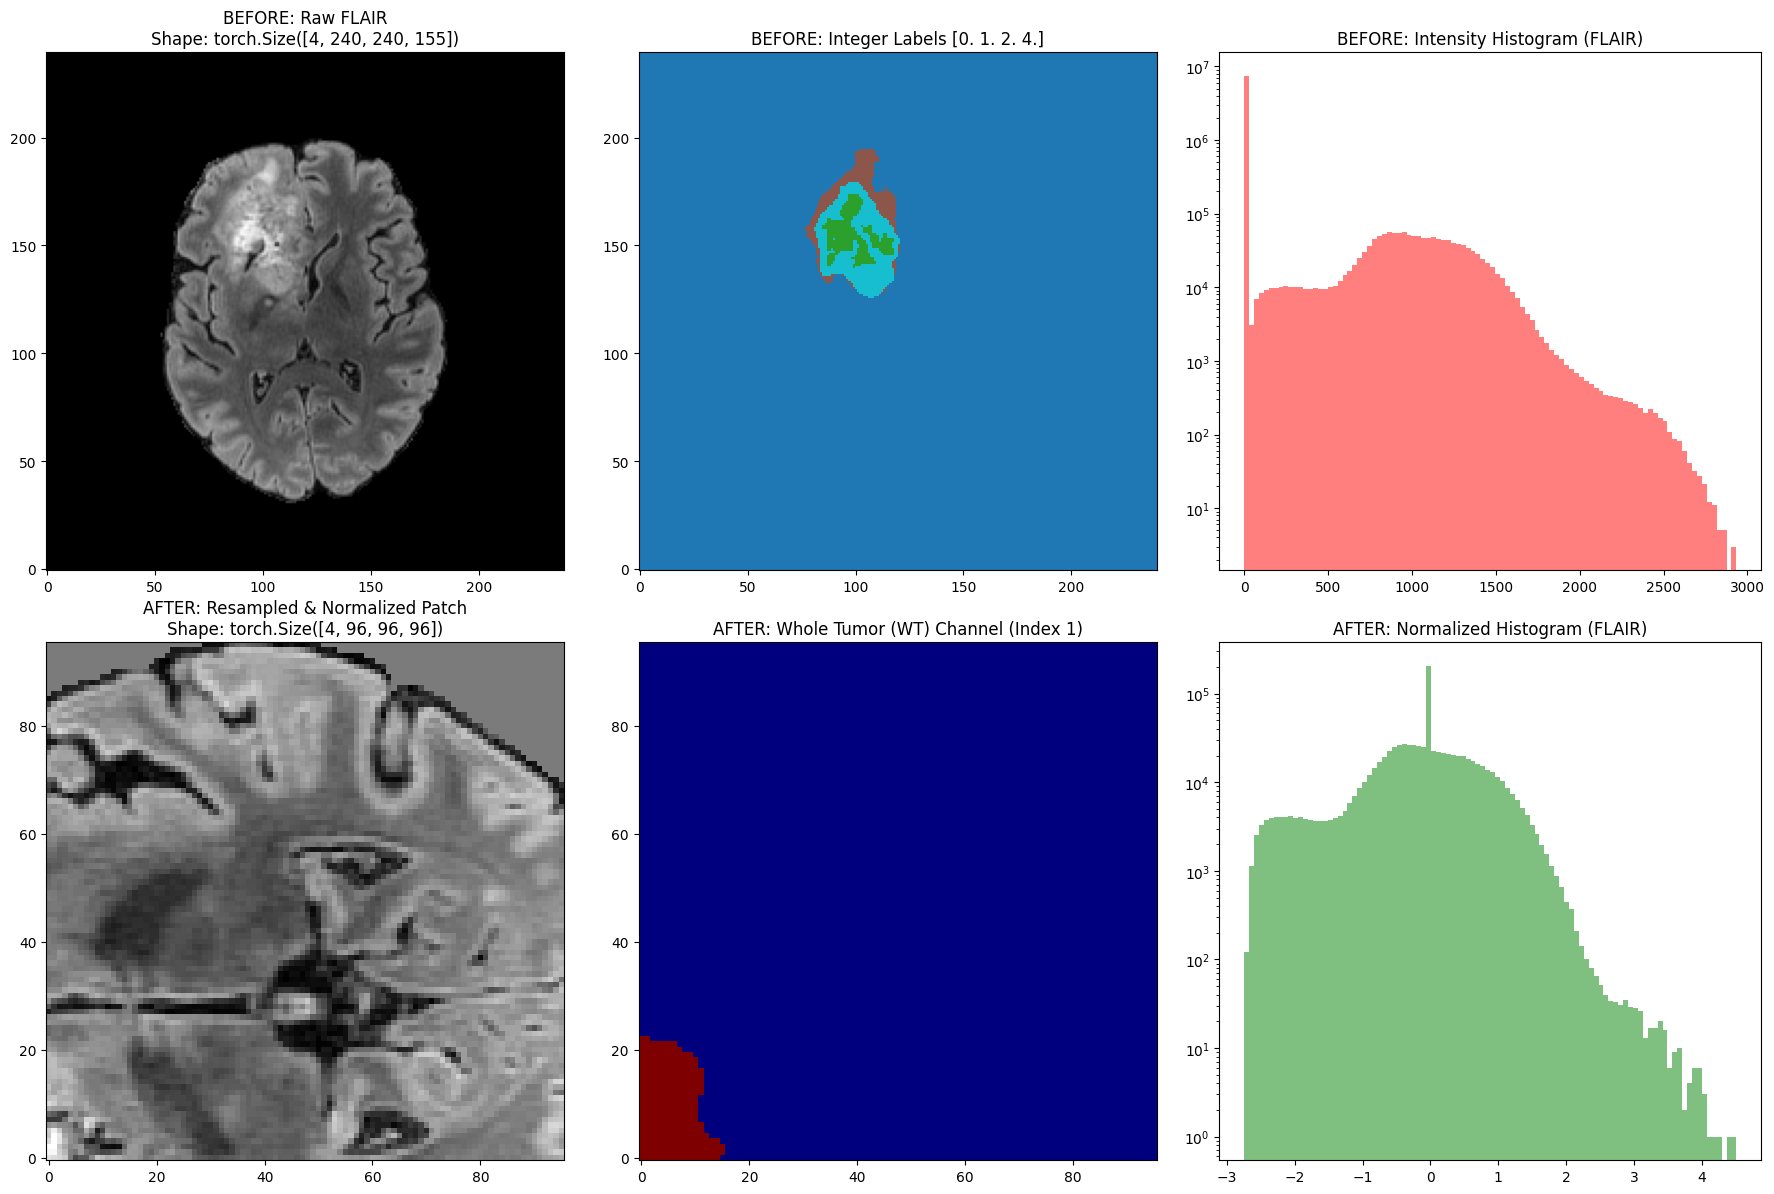

VERIFICATION COMPLETE
Label Mapping (4->3) REMOVED.
Raw image shape:       torch.Size([4, 240, 240, 155])
Raw label shape:       torch.Size([1, 240, 240, 155])
Processed image shape: torch.Size([4, 96, 96, 96]) (Should be patch size)
Processed label shape: torch.Size([3, 96, 96, 96]) (C=3 for TC/WT/ET)
Target Patch Size:     (96, 96, 96)


In [2]:
import os
import glob
import logging
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple, Callable

import numpy as np
import torch
import nibabel as nib
import matplotlib.pyplot as plt

from monai.data import CacheDataset, Dataset, DataLoader
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    NormalizeIntensityd,
    CropForegroundd,
    RandCropByPosNegLabeld,
    # MapLabelValued, # Removed
    RandFlipd,
    RandRotate90d,
    RandShiftIntensityd,
    ConvertToMultiChannelBasedOnBratsClassesd,
    SpatialPadd,
)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Suppress nibabel warnings
import warnings
warnings.filterwarnings("ignore")


# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================

@dataclass
class Config:
    """
    Central configuration for the preprocessing pipeline.
    """
    data_root: str = "/kaggle/input/brain-tumor-segmentation-hackathon"
    patch_size: Tuple[int, int, int] = (96, 96, 96)
    target_spacing: Tuple[float, float, float] = (1.0, 1.0, 1.0)
    use_augmentation: bool = True
    use_cache: bool = True
    cache_rate: float = 0.1  # Conservative default for Kaggle's 16GB RAM
    num_workers: int = 0     # 0 for Windows/Kaggle compatibility
    pos_neg_ratio: Tuple[int, int] = (1, 1)
    num_samples_per_image: int = 1


# ==============================================================================
# 2. FILE DISCOVERY
# ==============================================================================

def find_nifti_file(base_path: str, keyword: str) -> str:
    """
    Find a NIfTI file containing the keyword in nested folders.
    """
    candidates = glob.glob(os.path.join(base_path, "**", f"*{keyword}*.nii*"), recursive=True)
    real_files = [f for f in candidates if os.path.isfile(f)]
    
    if not real_files:
        raise FileNotFoundError(f"No valid file found for '{keyword}' in {base_path}")
    
    # Pick the deepest file to avoid matching parent directories
    return max(real_files, key=len)


def get_file_list(data_dir: str) -> List[Dict[str, any]]:
    """
    Scan the dataset directory and build a list of file dictionaries.
    """
    data_dicts = []
    patient_folders = sorted(glob.glob(os.path.join(data_dir, "BraTS2021_*")))
    
    print(f"Scanning {len(patient_folders)} patient folders...")
    
    skipped_count = 0
    for pat_path in patient_folders:
        patient_id = os.path.basename(pat_path)
        try:
            flair = find_nifti_file(pat_path, "flair")
            t1 = find_nifti_file(pat_path, "t1")
            t1ce = find_nifti_file(pat_path, "t1ce")
            t2 = find_nifti_file(pat_path, "t2")
            seg = find_nifti_file(pat_path, "seg")

            data_dicts.append({
                "image": [flair, t1, t1ce, t2],
                "label": seg
            })
            
        except FileNotFoundError as e:
            logger.warning(f"Skipping {patient_id}: {e}")
            skipped_count += 1
        except Exception as e:
            logger.error(f"Unexpected error for {patient_id}: {e}")
            skipped_count += 1
    
    if skipped_count > 0:
        logger.warning(f"Skipped {skipped_count} patients due to missing files")
    
    print(f"Successfully loaded {len(data_dicts)} valid patient volumes")
    return data_dicts


# ==============================================================================
# 3. TRANSFORM BUILDERS (MODULAR)
# ==============================================================================
def get_io_transforms() -> List:
    return [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
    ]

def get_preprocessing_transforms(config: Config) -> List:
    """
    Get preprocessing transforms (spacing, normalization, BraTS conversion).
    """
    return [
        # Resample to isotropic voxel spacing
        Spacingd(
            keys=["image", "label"],
            pixdim=config.target_spacing,
            mode=("bilinear", "nearest")
        ),
        
        # Convert to BraTS multi-channel format (standard labels 1, 2, 4):
        # Channel 0: Tumor Core (TC) = labels 1 (Necrotic) + 4 (Enhancing)
        # Channel 1: Whole Tumor (WT) = labels 1 (Necrotic) + 2 (Edema) + 4 (Enhancing)
        # Channel 2: Enhancing Tumor (ET) = label 4
        ConvertToMultiChannelBasedOnBratsClassesd(keys=["label"]),
        
        # Z-score normalization per channel, ignoring background zeros
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        
        # Remove empty border regions to reduce memory usage
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]


def get_patch_extraction_transforms(config: Config) -> List:
    """
    Get patch extraction transforms for training.
    """
    pos, neg = config.pos_neg_ratio
    return [
        # Ensure image is at least the size of the patch (crucial for stability)
        SpatialPadd(keys=["image", "label"], spatial_size=config.patch_size),
        
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=config.patch_size,
            pos=pos,
            neg=neg,
            num_samples=config.num_samples_per_image,
            image_key="image",
            image_threshold=0,
        ),
    ]
def get_augmentation_transforms() -> List:
    """
    Get data augmentation transforms for training.
    """
    return [
        # Spatial augmentations 
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        RandRotate90d(keys=["image", "label"], prob=0.5, max_k=3),
        
        # Intensity augmentation
        RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
    ]


def get_validation_spatial_transforms(config: Config) -> List:
    """
    Get spatial transforms for validation (deterministic, ensures padding for sliding window).
    """
    return [
        # Pad to ensure minimum size for sliding window inference
        SpatialPadd(keys=["image", "label"], spatial_size=config.patch_size),
    ]


# ==============================================================================
# 4. PIPELINE ASSEMBLY
# ==============================================================================

def build_raw_transforms() -> Compose:
    """
    Build a minimal transform pipeline for raw data visualization.
    """
    transforms = get_io_transforms()
    # If using raw visualization, we may want to include a minimal map here,
    # but for simplicity, we use the bare IO pipeline.
    return Compose(transforms)


def build_train_transforms(config: Config) -> Compose:
    """
    Build the complete training transform pipeline.
    """
    transforms = []
    transforms.extend(get_io_transforms())
    transforms.extend(get_preprocessing_transforms(config))
    transforms.extend(get_patch_extraction_transforms(config))
    
    if config.use_augmentation:
        transforms.extend(get_augmentation_transforms())
        print("Training augmentation: ENABLED")
    else:
        print("Training augmentation: DISABLED")
    
    return Compose(transforms)


def build_val_transforms(config: Config) -> Compose:
    """
    Build the validation transform pipeline.
    """
    transforms = []
    transforms.extend(get_io_transforms())
    transforms.extend(get_preprocessing_transforms(config))
    transforms.extend(get_validation_spatial_transforms(config))
    
    return Compose(transforms)


# ==============================================================================
# 5. DATASET FACTORY
# ==============================================================================

def create_dataset(
    file_list: List[Dict],
    transforms: Compose,
    config: Config,
    is_train: bool = True
) -> Dataset:
    """
    Create a MONAI dataset with configurable caching.
    """
    if config.use_cache and config.cache_rate > 0:
        print(
            f"Creating CacheDataset with cache_rate={config.cache_rate}, "
            f"num_workers={config.num_workers}"
        )
        return CacheDataset(
            data=file_list,
            transform=transforms,
            cache_rate=config.cache_rate,
            num_workers=config.num_workers,
        )
    else:
        print("Creating standard Dataset (no caching)")
        return Dataset(data=file_list, transform=transforms)


def create_dataloader(
    dataset: Dataset,
    batch_size: int = 2,
    shuffle: bool = True,
    num_workers: int = 0,
) -> DataLoader:
    """
    Create a DataLoader for the given dataset.
    """
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
    )


# ==============================================================================
# 6. VISUALIZATION UTILITIES (Optional)
# ==============================================================================

def visualize_sample(
    raw_item: Dict,
    proc_item: Dict,
    save_path: Optional[str] = None
) -> None:
    """
    Visualize a sample before and after preprocessing.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Extract data
    raw_img = raw_item["image"]
    raw_seg = raw_item["label"]
    proc_img = proc_item["image"]
    proc_seg = proc_item["label"]  # Shape: (3, H, W, D) after BraTS conversion
    
    # Get middle slices
    # Raw data might have different dimensions, use index 0 channel (FLAIR)
    raw_slice = raw_img.shape[3] // 2
    proc_slice = proc_img.shape[3] // 2
    
    # --- Row 1: Raw Data ---
    axes[0, 0].imshow(raw_img[0, :, :, raw_slice].T, cmap="gray", origin="lower")
    axes[0, 0].set_title(f"BEFORE: Raw FLAIR\nShape: {raw_img.shape}")
    
    # The raw label might contain 0, 1, 2, 4
    raw_labels = np.unique(raw_seg[0].numpy())
    axes[0, 1].imshow(raw_seg[0, :, :, raw_slice].T, cmap="tab10", origin="lower", interpolation="nearest")
    axes[0, 1].set_title(f"BEFORE: Integer Labels {raw_labels}")
    
    axes[0, 2].hist(raw_img[0].flatten(), bins=100, color='red', alpha=0.5)
    axes[0, 2].set_title("BEFORE: Intensity Histogram (FLAIR)")
    axes[0, 2].set_yscale('log')
    
    # --- Row 2: Processed Data ---
    # Processed data is a patch (96, 96, 96)
    axes[1, 0].imshow(proc_img[0, :, :, proc_slice].T, cmap="gray", origin="lower")
    axes[1, 0].set_title(f"AFTER: Resampled & Normalized Patch\nShape: {proc_img.shape}")
    
    # Show Whole Tumor channel (index 1)
    # This channel is WT = 1 + 2 + 4
    axes[1, 1].imshow(proc_seg[1, :, :, proc_slice].T, cmap="jet", origin="lower", interpolation="nearest")
    axes[1, 1].set_title("AFTER: Whole Tumor (WT) Channel (Index 1)")
    
    axes[1, 2].hist(proc_img[0].flatten(), bins=100, color='green', alpha=0.5)
    axes[1, 2].set_title("AFTER: Normalized Histogram (FLAIR)")
    axes[1, 2].set_yscale('log')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    else:
        plt.show()
    
    plt.close()


# ==============================================================================
# 7. MAIN EXECUTION (Demo/Testing)
# ==============================================================================

if __name__ == "__main__":
    # Initialize configuration
    config = Config(
        use_augmentation=True,
        use_cache=True,
        cache_rate=1.0,  # Cache single sample for demo
        num_workers=0,
    )
    
    # Discover files
    files = get_file_list(config.data_root)
    
    if len(files) == 0:
        logger.error("CRITICAL: No files were found. Check DATA_ROOT path.")
        exit(1)
    
    print(f"\n--- Testing Preprocessing Pipeline on 1 sample ---")
    
    # Use single sample for demonstration
    sample_data = [files[0]]
    
    # Build transforms
    raw_transforms = build_raw_transforms()
    train_transforms = build_train_transforms(config)
    val_transforms = build_val_transforms(config)
    
    # --- 1. Load raw sample ---
    print("\nLoading raw data (minimal transforms)...")
    ds_raw = Dataset(data=sample_data, transform=raw_transforms)
    raw_item = ds_raw[0]
    
    # --- 2. Load processed sample (Train Pipeline) ---
    print("Applying training pipeline (resampling, normalization, cropping)...")
    ds_proc = create_dataset(sample_data, train_transforms, config)
    proc_item_container = ds_proc[0]
    
    # Handle RandCrop output (returns list)
    if isinstance(proc_item_container, list):
        proc_item = proc_item_container[0]
    else:
        proc_item = proc_item_container
    
    # --- 3. Visualize ---
    visualize_sample(raw_item, proc_item)
    
    # Print verification info
    print("=" * 60)
    print("VERIFICATION COMPLETE")
    print("Label Mapping (4->3) REMOVED.")
    print("=" * 60)
    print(f"Raw image shape:       {raw_item['image'].shape}")
    print(f"Raw label shape:       {raw_item['label'].shape}")
    print(f"Processed image shape: {proc_item['image'].shape} (Should be patch size)")
    print(f"Processed label shape: {proc_item['label'].shape} (C=3 for TC/WT/ET)")
    print(f"Target Patch Size:     {config.patch_size}")
    print("=" * 60)

In [3]:
# import os
# import glob
# import logging
# import time
# import sys 
# import random 
# from dataclasses import dataclass, field
# from typing import List, Dict, Optional, Tuple, Callable

# import numpy as np
# import torch
# import nibabel as nib
# from tqdm.auto import tqdm 

# # MONAI Imports
# from monai.data import CacheDataset, Dataset, DataLoader, decollate_batch
# from monai.transforms import (
#     Compose,
#     LoadImaged,
#     EnsureChannelFirstd,
#     Orientationd,
#     Spacingd,
#     NormalizeIntensityd,
#     CropForegroundd,
#     RandCropByPosNegLabeld,
#     RandFlipd,
#     RandRotate90d,
#     RandShiftIntensityd,
#     ConvertToMultiChannelBasedOnBratsClassesd,
#     SpatialPadd,
#     Activations,
#     AsDiscrete,
#     Invertd 
# )
# from monai.utils import set_determinism
# from monai.networks.nets import SegResNet
# from monai.losses import DiceCELoss 
# from monai.metrics import DiceMetric
# from monai.inferers import sliding_window_inference


# --- Custom Dual Logger Class ---
class DualLogger:
    """Logs messages to both console (stdout) and a file."""
    def __init__(self, filepath: str, console_logging: bool = True):
        self.filepath = filepath
        self.file = open(filepath, "a", buffering=1) 
        self.console_logging = console_logging
        self.stdout = sys.stdout
        self.log(f"--- Session Started: {time.ctime()} ---")

    def log(self, message: str):
        """Writes the message to the console and the file immediately."""
        full_message = f"{message}"
        
        if self.console_logging:
            self.stdout.write(full_message + '\n')
            self.stdout.flush()
        
        self.file.write(full_message + '\n')
        self.file.flush() 

    def __del__(self):
        if hasattr(self, 'file') and not self.file.closed:
            self.log(f"--- Session Ended: {time.ctime()} ---")
            self.file.close()

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings("ignore")


# # ==============================================================================
# # 1. CONFIGURATION
# # ==============================================================================

# @dataclass
# class Config:
#     """Central configuration for the preprocessing pipeline."""
#     data_root: str = "/kaggle/input/brain-tumor-segmentation-hackathon"
#     patch_size: Tuple[int, int, int] = (96, 96, 96)
#     target_spacing: Tuple[float, float, float] = (1.0, 1.0, 1.0)
#     use_augmentation: bool = True
#     use_cache: bool = False 
#     cache_rate: float = 0.0
#     num_workers: int = 0
#     pos_neg_ratio: Tuple[int, int] = (1, 1)
#     num_samples_per_image: int = 1


# @dataclass
# class TrainConfig:
#     """Configuration for the training process."""
#     max_epochs: int = 12
#     train_batch_size: int = 1
#     val_batch_size: int = 1
#     val_interval: int = 4                
#     learning_rate: float = 2e-4
#     seed: int = 0
#     model_save_path: str = "best_model.pth"
#     log_file: str = "training_log.txt"   

# # ==============================================================================
# # 2. FILE DISCOVERY (Kept the same)
# # ==============================================================================

# def find_nifti_file(base_path: str, keyword: str) -> str:
#     candidates = glob.glob(os.path.join(base_path, "**", f"*{keyword}*.nii*"), recursive=True)
#     real_files = [f for f in candidates if os.path.isfile(f)]
#     if not real_files:
#         raise FileNotFoundError(f"No valid file found for '{keyword}' in {base_path}")
#     return max(real_files, key=len)


# def get_file_list(data_dir: str, dual_logger: DualLogger) -> List[Dict[str, any]]:
#     data_dicts = []
#     patient_folders = sorted(glob.glob(os.path.join(data_dir, "BraTS2021_*")))
    
#     dual_logger.log(f"Scanning {len(patient_folders)} patient folders...")
    
#     skipped_count = 0
#     for pat_path in patient_folders:
#         if not os.path.isdir(pat_path): continue
             
#         patient_id = os.path.basename(pat_path)
#         try:
#             flair = find_nifti_file(pat_path, "flair")
#             t1 = find_nifti_file(pat_path, "t1")
#             t1ce = find_nifti_file(pat_path, "t1ce")
#             t2 = find_nifti_file(pat_path, "t2")
#             seg = find_nifti_file(pat_path, "seg")

#             try:
#                 numeric_id = int(patient_id.split('_')[-1])
#             except ValueError:
#                 numeric_id = 0 

#             data_dicts.append({
#                 "image": [flair, t1, t1ce, t2],
#                 "label": seg,
#                 "patient_id": numeric_id
#             })
            
#         except FileNotFoundError as e:
#             skipped_count += 1
#         except Exception as e:
#             logger.error(f"Unexpected error for {patient_id}: {e}")
#             skipped_count += 1
    
#     if skipped_count > 0:
#         logger.warning(f"Skipped {skipped_count} patients due to missing files")
    
#     dual_logger.log(f"Successfully loaded {len(data_dicts)} valid patient volumes with SEG masks.")
#     return data_dicts


# # ==============================================================================
# # 3. TRANSFORM & 4. DATASET UTILS (Kept the same)
# # ==============================================================================
# def get_io_transforms() -> List:
#     return [LoadImaged(keys=["image", "label"]), EnsureChannelFirstd(keys=["image", "label"]), Orientationd(keys=["image", "label"], axcodes="RAS")]
# def get_preprocessing_transforms(config: Config) -> List:
#     return [Spacingd(keys=["image", "label"], pixdim=config.target_spacing, mode=("bilinear", "nearest")), ConvertToMultiChannelBasedOnBratsClassesd(keys=["label"]), NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True), CropForegroundd(keys=["image", "label"], source_key="image")]
# def get_patch_extraction_transforms(config: Config) -> List:
#     pos, neg = config.pos_neg_ratio
#     return [SpatialPadd(keys=["image", "label"], spatial_size=config.patch_size), RandCropByPosNegLabeld(keys=["image", "label"], label_key="label", spatial_size=config.patch_size, pos=pos, neg=neg, num_samples=config.num_samples_per_image, image_key="image", image_threshold=0),]
# def get_augmentation_transforms() -> List:
#     return [RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0), RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1), RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2), RandRotate90d(keys=["image", "label"], prob=0.5, max_k=3), RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),]
# def get_validation_spatial_transforms(config: Config) -> List:
#     return [SpatialPadd(keys=["image", "label"], spatial_size=config.patch_size),]
# def build_train_transforms(config: Config) -> Compose:
#     transforms = get_io_transforms() + get_preprocessing_transforms(config) + get_patch_extraction_transforms(config)
#     if config.use_augmentation: transforms.extend(get_augmentation_transforms())
#     return Compose(transforms)
# def build_val_transforms(config: Config) -> Compose:
#     return Compose(get_io_transforms() + get_preprocessing_transforms(config) + get_validation_spatial_transforms(config))
# def create_dataset(file_list: List[Dict], transforms: Compose, config: Config, is_train: bool = True) -> Dataset:
#     return Dataset(data=file_list, transform=transforms)
# def create_dataloader(dataset: Dataset, batch_size: int = 2, shuffle: bool = True, num_workers: int = 0) -> DataLoader:
#     return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
# def check_cuda(dual_logger: DualLogger):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     dual_logger.log(f"Device Selected: {device}")
#     if device.type == 'cuda': torch.backends.cudnn.benchmark = True
#     return device


# # ==============================================================================
# # 5. TRAINING LOOP (CRITICAL MODIFICATION HERE)
# # ==============================================================================

# def train_segmentation(config: Config, train_config: TrainConfig):
#     # Initialize Dual Logger
#     dual_logger = DualLogger(filepath=train_config.log_file)
    
#     # 0. Initial Setup
#     set_determinism(seed=train_config.seed)
#     device = check_cuda(dual_logger)
#     CHECKPOINT_DIR = "checkpoints"
#     os.makedirs(CHECKPOINT_DIR, exist_ok=True)

    
#     dual_logger.log("\n--- Phase 1: Data Preparation ---")
#     all_files = get_file_list(config.data_root, dual_logger)
    
#     if len(all_files) < 1:
#         raise RuntimeError("No files found.")

#     # --- CRITICAL SPLIT LOGIC CHANGE: Combining all data for training ---
    
#     original_train_files, original_val_files = [], []
    
#     # 1. Separate based on the requested manual split (BraTS 2021 ID 1333 to 1666)
#     for item in all_files:
#         patient_id = item.get("patient_id", 0) 
#         if 1333 <= patient_id <= 1666:
#             # This subset is now the 'Validation/Test' set
#             original_val_files.append(item) 
#         else:
#             # This subset is the 'Original Train' set
#             original_train_files.append(item) 
            
#     # 2. Define Training Set (Original Train + Original Val/Test)
#     train_files = original_train_files + original_val_files
#     random.seed(train_config.seed) 
#     random.shuffle(train_files) 
    
#     # 3. Define Validation Set (Only the Original Val/Test Set)
#     val_files = original_val_files

#     if not val_files:
#          raise RuntimeError("Validation set is empty based on the specified ID range. Cannot proceed with validation tracking.")

#     dual_logger.log(f"--- Deployment Phase Split Strategy ---")
#     dual_logger.log(f"Original Training pool size: {len(original_train_files)}")
#     dual_logger.log(f"Validation/Test pool size (IDs 1333-1666): {len(val_files)}")
#     dual_logger.log(f"Final Training Set Size (Combined): {len(train_files)}")
#     dual_logger.log(f"Final Validation Set Size (Subset): {len(val_files)}")


#     # 4. Datasets and Loaders
#     train_trans = build_train_transforms(config)
#     val_trans = build_val_transforms(config)
    
#     train_ds = create_dataset(train_files, train_trans, config)
#     val_ds = create_dataset(val_files, val_trans, config)

#     train_loader = create_dataloader(train_ds, batch_size=train_config.train_batch_size, shuffle=True, num_workers=config.num_workers)
#     val_loader = create_dataloader(val_ds, batch_size=train_config.val_batch_size, shuffle=False, num_workers=config.num_workers)

#     # Define Inverter 
#     inverter = Invertd(
#         keys=["pred", "label"],
#         transform=val_trans,
#         orig_keys="image",
#         meta_keys=["pred_meta_dict", "label_meta_dict"],
#         orig_meta_keys="image_meta_dict",
#         nearest_interp=True,
#         to_tensor=True,
#     )

#     dual_logger.log("\n--- Phase 2: Model Initialization ---")
#     model = SegResNet(
#         spatial_dims=3,
#         init_filters=32,
#         in_channels=4,
#         out_channels=3, 
#     ).to(device)

#     loss_function = DiceCELoss(sigmoid=True, squared_pred=True)
#     optimizer = torch.optim.Adam(model.parameters(), lr=train_config.learning_rate)

#     train_dice_metric = DiceMetric(include_background=True, reduction="mean_batch", num_classes=3)
#     val_dice_metric = DiceMetric(include_background=True, reduction="mean_batch", num_classes=3)

#     post_trans = Compose([
#         Activations(sigmoid=True),
#         AsDiscrete(threshold=0.5)
#     ])

#     dual_logger.log("\n--- Phase 3: Start Training ---")
#     best_metric = -1
#     best_metric_epoch = -1

#     for epoch in range(train_config.max_epochs):
#         epoch_start = time.time()
#         model.train()
        
#         # --- TRAINING LOOP ---
#         train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{train_config.max_epochs} [Train]")
#         epoch_loss = 0
        
#         for batch_data in train_pbar:
#             inputs = batch_data["image"].to(device).float()
#             labels = batch_data["label"].to(device).float()
            
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = loss_function(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             epoch_loss += loss.item()
#             curr_preds = [post_trans(i) for i in decollate_batch(outputs)]
#             curr_labels = decollate_batch(labels)
#             train_dice_metric(y_pred=curr_preds, y=curr_labels)
            
#             train_pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        
#         t_m = train_dice_metric.aggregate()
#         t_m_mean = t_m.mean().item()
        
#         log_message = (
#             f"\nEpoch {epoch+1} Train Metrics:\n"
#             f"  Avg Loss: {epoch_loss / len(train_loader):.4f}\n"
#             f"  Dice (Patch) -> Mean: {t_m_mean:.4f} | TC: {t_m[0]:.4f} | WT: {t_m[1]:.4f} | ET: {t_m[2]:.4f}"
#         )
#         dual_logger.log(log_message)
#         train_dice_metric.reset()

#         # --- VALIDATION LOOP (Every val_interval epochs) ---
#         if (epoch + 1) % train_config.val_interval == 0:
#             model.eval()
#             with torch.no_grad():
#                 val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{train_config.max_epochs} [Val on Subset]")
                
#                 for val_data in val_pbar:
#                     val_inputs = val_data["image"].to(device).float()
                    
#                     val_data["pred"] = sliding_window_inference(
#                         val_inputs, config.patch_size, sw_batch_size=4, predictor=model, overlap=0.5
#                     )
                    
#                     val_data["pred"] = val_data["pred"].cpu()
#                     inverted_data = [inverter(d) for d in decollate_batch(val_data)]
                    
#                     val_dice_metric(
#                         y_pred=[post_trans(i["pred"]).to(device) for i in inverted_data], 
#                         y=[i["label"].to(device) for i in inverted_data]
#                     )

#                 v_m = val_dice_metric.aggregate()
#                 mean_val_dice = v_m.mean().item()
#                 val_dice_metric.reset()
                
#                 log_message = (
#                     f"Epoch {epoch+1} Validation Metrics (On Test Subset):\n"
#                     f"  Mean Dice: {mean_val_dice:.4f} | TC: {v_m[0]:.4f} | WT: {v_m[1]:.4f} | ET: {v_m[2]:.4f}"
#                 )
#                 dual_logger.log(log_message)
                
#                 # Save checkpoint
#                 checkpoint_path = os.path.join(CHECKPOINT_DIR, f"epoch_{epoch+1}_dice_{mean_val_dice:.4f}.pth")
#                 torch.save(model.state_dict(), checkpoint_path)
#                 dual_logger.log(f"  Checkpoint saved to {checkpoint_path}")

#                 # Save best model
#                 if mean_val_dice > best_metric:
#                     best_metric = mean_val_dice
#                     best_metric_epoch = epoch + 1
#                     torch.save(model.state_dict(), train_config.model_save_path)
#                     dual_logger.log(f">>> New Best Model Saved! (Mean Dice: {mean_val_dice:.4f})")
#                 else:
#                     dual_logger.log(f"  (No improvement. Best was {best_metric:.4f} at epoch {best_metric_epoch})")


#         dual_logger.log(f"Epoch {epoch+1} Total Time: {time.time() - epoch_start:.2f}s\n")

#     dual_logger.log("=" * 60)
#     dual_logger.log("Training Finished.")
#     dual_logger.log(f"Best Mean Dice: {best_metric:.4f} at Epoch {best_metric_epoch}")
#     dual_logger.log("=" * 60)

# # ==============================================================================
# # 6. EXECUTION
# # ==============================================================================
# if __name__ == "__main__":
#     data_config = Config(
#         data_root="/kaggle/input/brain-tumor-segmentation-hackathon", 
#         patch_size=(96, 96, 96),
#         use_cache=False, 
#         num_workers=0 
#     )

#     train_cfg = TrainConfig(
#         max_epochs=8, 
#         val_interval=4,
#         log_file="deployment_training_run.log"
#     )

#     try:
#         train_segmentation(data_config, train_cfg)
#     except Exception as e:
#         logger.error(f"Failed during training: {e}", exc_info=True)

In [4]:
import os
import torch
import numpy as np
import pandas as pd
import nibabel as nib
from skimage import morphology
from monai.networks.nets import SegResNet
from monai.transforms import (
    Compose, LoadImaged, EnsureTyped, NormalizeIntensityd, 
    Orientationd, EnsureChannelFirstd, Spacingd, Invertd
)
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch

# ==============================================================================
# 1. SETUP
# ==============================================================================
BASE_PATH = '/kaggle/input/brain-tumor-segmentation-hackathon'
TEST_DATA_DIR = "/kaggle/input/brain-tumor-segmentation-hackathon"
SAMPLE_SUB_PATH = "/kaggle/input/samples/sample_submission.csv"
MODEL_WEIGHTS = "/kaggle/input/models/best_model.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================================================================
# 2. UTILS
# ==============================================================================
def rle_encode(mask):
    """Converts binary mask to RLE string (Fortran order is standard for BraTS)."""
    pixels = mask.flatten(order='C')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def clean_mask(mask, min_size=50):
    """Removes small noisy fragments."""
    if np.sum(mask) > 0:
        return morphology.remove_small_objects(mask.astype(bool), min_size=min_size).astype(np.uint8)
    return mask

def find_file(patient_folder, p_id, suffix):
    for ext in ['.nii.gz', '.nii']:
        path = os.path.join(patient_folder, f"{p_id}_{suffix}{ext}")
        if os.path.exists(path): return path
    return None

# ==============================================================================
# 3. MODEL & TRANSFORMS
# ==============================================================================
model = SegResNet(
    spatial_dims=3,
    init_filters=32, # Change to 32 if your model was trained with 32
    in_channels=4,
    out_channels=3,
).to(DEVICE)

model.load_state_dict(torch.load(MODEL_WEIGHTS, map_location=DEVICE))
model.eval()

# IMPORTANT: Include Spacingd if your model was trained on 1mm isotropic data
test_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    EnsureTyped(keys=["image"]),
])

# This reverses orientation and resampling back to the original NIfTI header
inverter = Invertd(
    keys="pred",
    transform=test_transforms,
    orig_keys="image",
    meta_keys="pred_meta_dict",
    orig_meta_keys="image_meta_dict",
    nearest_interp=True,
    to_tensor=True,
)

# ==============================================================================
# 4. INFERENCE LOOP
# ==============================================================================
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)
patient_ids = sample_sub['id'].apply(lambda x: "_".join(x.split('_')[:-1])).unique()


submission_data = []

print(f"Processing {len(patient_ids)} patients...")

with torch.no_grad():
    for p_id in patient_ids:
        patient_folder = os.path.join(TEST_DATA_DIR, p_id)
        flair = find_file(patient_folder, p_id, "flair")
        t1 = find_file(patient_folder, p_id, "t1")
        t1ce = find_file(patient_folder, p_id, "t1ce")
        t2 = find_file(patient_folder, p_id, "t2")

        if flair:
            # Load and Preprocess
            data_dict = {"image": [flair, t1, t1ce, t2]}
            prepped = test_transforms(data_dict)
            input_tensor = prepped["image"].unsqueeze(0).to(DEVICE)

            # 1. Inference in Processed Space
            output = sliding_window_inference(input_tensor, (96, 96, 96), 4, model)
            output = torch.sigmoid(output) 

            # 2. Invert to Original Space (Crucial for RLE alignment)
            prepped["pred"] = output[0] # remove batch dim for inverter
            inverted = inverter(prepped)
            
            # 3. Get predictions and apply threshold
            # Channels: 0:TC, 1:WT, 2:ET
            preds = (inverted["pred"].cpu().numpy() > 0.3).astype(np.uint8)
            
            tc_mask = clean_mask(preds[0])
            wt_mask = clean_mask(preds[1])
            et_mask = clean_mask(preds[2])

            # 4. Logical Reconstruction (Fixing the Swap)
            # Label 2 (Edema): WT but not TC
            # Label 1 (Necrotic): TC but not ET
            # Label 4 (Enhancing): ET
            final_mask = np.zeros(tc_mask.shape, dtype=np.uint8)
            
            final_mask[(wt_mask == 1) & (tc_mask == 0)] = 2
            final_mask[(tc_mask == 1) & (et_mask == 0)] = 1
            final_mask[et_mask == 1] = 4
            
        else:
            # Fallback for missing files
            final_mask = np.zeros((240, 240, 155), dtype=np.uint8)
            print("Zeros")

        # 5. RLE Encoding
        for label in [1, 2, 4]:
            binary_mask = (final_mask == label).astype(np.uint8)
            rle_str = rle_encode(binary_mask)
            submission_data.append({
                'id': f"{p_id}_{label}",
                'rle': rle_str if rle_str else "" 
            })

# ==============================================================================
# 5. SAVE
# ==============================================================================
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv('submission.csv', index=False)
print("Success: submission.csv generated.")

Processing 334 patients...
Success: submission.csv generated.


In [5]:
import nibabel as nib
import numpy as np
import pandas as pd

# ==============================================================================
# 1. SETUP PATH
# ==============================================================================
SEG_FILE_PATH = "/kaggle/input/brain-tumor-segmentation-hackathon/BraTS2021_01333/BraTS2021_01333_seg.nii"
p_id = "BraTS2021_01333"

# ==============================================================================
# 2. RLE UTILS (Matches your structure, fixed to Fortran Order 'F')
# ==============================================================================
def rle_encode(mask):
    """Converts binary mask to RLE string. 
    Using order='C' is standard for NIfTI/BraTS competitions."""
    pixels = mask.flatten(order='C') 
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# ==============================================================================
# 3. LOAD AND ENCODE
# ==============================================================================
print(f"Loading segmentation file: {SEG_FILE_PATH}")
seg_img = nib.load(SEG_FILE_PATH)
seg_data = seg_img.get_fdata()

submission_data = []

# BraTS labels are 1 (Necrotic), 2 (Edema), and 4 (Enhancing)
for label in [1, 2, 4]:
    print(f"Encoding label {label}...")
    # Create binary mask for the specific label
    binary_mask = (seg_data == label).astype(np.uint8)
    
    # Generate RLE string
    rle_str = rle_encode(binary_mask)
    
    submission_data.append({
        'id': f"{p_id}_{label}",
        'rle': rle_str if rle_str else "" 
    })

# ==============================================================================
# 4. SAVE & PREVIEW
# ==============================================================================
df = pd.DataFrame(submission_data)
df.to_csv('gt_submission_00133.csv', index=False)

print("\nSuccess: gt_submission_01333.csv generated.")
print("-" * 30)
for index, row in df.iterrows():
    print(f"ID: {row['id']}")
    print(f"RLE Snippet: {row['rle'][:100]}...")
    print("-" * 30)

Loading segmentation file: /kaggle/input/brain-tumor-segmentation-hackathon/BraTS2021_01333/BraTS2021_01333_seg.nii
Encoding label 1...
Encoding label 2...
Encoding label 4...

Success: gt_submission_01333.csv generated.
------------------------------
ID: BraTS2021_01333_1
RLE Snippet: 3891868 1 3892014 1 3928911 4 3929059 10 3929214 2 3966259 4 3966266 4 3966414 1...
------------------------------
ID: BraTS2021_01333_2
RLE Snippet: 3371219 1 3408108 3 3408261 6 3408416 6 3408572 5 3445152 5 3445305 8 3445460 8 3445615 8 3445771 7 ...
------------------------------
ID: BraTS2021_01333_4
RLE Snippet: 3668201 2 3668354 5 3668509 4 3668664 4 3705243 6 3705395 9 3705550 9 3705705 8 3705860 8 3706016 7 ...
------------------------------


In [6]:
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import tqdm
import sys 
import time
import logging # Required for standard logging setup

# --- Custom Dual Logger Class ---
class DualLogger:
    """Logs messages to both console (stdout) and a file."""
    def __init__(self, filepath: str, console_logging: bool = True):
        self.filepath = filepath
        # Ensure directory exists if needed, though usually /kaggle/working exists
        os.makedirs(os.path.dirname(filepath) or '.', exist_ok=True) 
        self.file = open(filepath, "a", buffering=1) 
        self.console_logging = console_logging
        self.stdout = sys.stdout
        self.log(f"--- Session Started: {time.ctime()} ---")

    def log(self, message: str):
        """Writes the message to the console and the file immediately."""
        full_message = f"{message}"
        
        if self.console_logging:
            # We use stdout.write here to ensure proper flushing
            self.stdout.write(full_message + '\n')
            self.stdout.flush()
        
        self.file.write(full_message + '\n')
        self.file.flush() 

    def __del__(self):
        if hasattr(self, 'file') and not self.file.closed:
            self.log(f"--- Session Ended: {time.ctime()} ---")
            self.file.close()

# Initialize Standard Logging (Used if DualLogger fails or for other system messages)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings("ignore")

# --- INITIALIZE CUSTOM LOGGER ---
LOG_FILE_PATH = "evaluation_log.txt"
dual_logger = DualLogger(filepath=LOG_FILE_PATH)
dual_logger.log(f"Logging output to {LOG_FILE_PATH}")
# --------------------------------

# ==============================================================================
# 1. UTILITIES
# ==============================================================================

def rle_encode_c_order(mask):
    """Encodes a binary mask to RLE using Row-Major (C) order."""
    pixels = mask.flatten(order='C')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_to_set(rle_str):
    """Converts an RLE string into a set of pixel indices."""
    if pd.isna(rle_str) or rle_str == "" or rle_str == "1 0":
        return set()
    s = list(map(int, rle_str.split()))
    indices = set()
    for i in range(0, len(s), 2):
        start, length = s[i], s[i+1]
        indices.update(range(start, start + length))
    return indices

def calculate_dice(set_a, set_b):
    """Calculates the Dice Coefficient between two sets."""
    size_a, size_b = len(set_a), len(set_b)
    if size_a + size_b == 0:
        return 1.0 
    intersection = len(set_a.intersection(set_b))
    return (2.0 * intersection) / (size_a + size_b)

def find_seg_file_robust(patient_dir, p_id):
    """
    Recursively searches for a segmentation file within the patient folder.
    Looks for files containing 'seg' and ending in .nii or .nii.gz.
    """
    pattern = os.path.join(patient_dir, "**", "*seg*.nii*")
    candidates = glob.glob(pattern, recursive=True)
    
    valid_files = [f for f in candidates if os.path.isfile(f) and os.path.getsize(f) > 0]
    
    if not valid_files:
        return None
    
    # Priority: Pick file that contains the exact patient ID in its name
    for f in valid_files:
        if p_id in os.path.basename(f):
            return f
            
    return valid_files[0]

# ==============================================================================
# 2. CONFIGURATION
# ==============================================================================
SUBMISSION_PATH = '/kaggle/working/submission.csv'
GT_ROOT = '/kaggle/input/brain-tumor-segmentation-hackathon'
LABELS = [1, 2, 4]

try:
    df_pred = pd.read_csv(SUBMISSION_PATH)
except FileNotFoundError:
    dual_logger.log(f"Error: Submission file not found at {SUBMISSION_PATH}")
    sys.exit(1)

pred_lookup = dict(zip(df_pred['id'], df_pred['rle']))
patient_ids = sorted(list(set(["_".join(x.split('_')[:-1]) for x in df_pred['id']])))

# ==============================================================================
# 3. EVALUATION LOOP
# ==============================================================================
results = []
skipped = []

dual_logger.log(f"Analyzing {len(patient_ids)} patients from prediction file...")

for p_id in tqdm(patient_ids, desc="Evaluating Patients"):
    patient_dir = os.path.join(GT_ROOT, p_id)
    
    if not os.path.exists(patient_dir):
        parent_search = glob.glob(os.path.join(GT_ROOT, f"{p_id}*"))
        if parent_search:
            patient_dir = parent_search[0]
        else:
            dual_logger.log(f"Missing folder for {p_id}")
            skipped.append(p_id)
            continue

    gt_path = find_seg_file_robust(patient_dir, p_id)
    
    if gt_path is None:
        dual_logger.log(f"Seg file not found or empty for {p_id}")
        skipped.append(p_id)
        continue

    try:
        gt_data = nib.load(gt_path).get_fdata()

        for label in LABELS:
            full_id = f"{p_id}_{label}"
            
            # Get Pred RLE
            set_pred = rle_to_set(pred_lookup.get(full_id, ""))

            # Generate GT RLE (C-Order)
            binary_gt = (gt_data == label).astype(np.uint8)
            set_gt = rle_to_set(rle_encode_c_order(binary_gt))

            score = calculate_dice(set_pred, set_gt)
            results.append({'p_id': p_id, 'label': label, 'dice': score})
            
    except Exception as e:
        dual_logger.log(f"Error processing GT for {p_id}: {e}")
        skipped.append(p_id)

# ==============================================================================
# 4. RESULTS
# ==============================================================================
if results:
    results_df = pd.DataFrame(results)
    
    dual_logger.log("\n" + "="*50)
    dual_logger.log("FINAL DICE SCORES")
    dual_logger.log("="*50)
    
    # Use a list to build the log message for the summary table
    summary_lines = []
    
    for label in LABELS:
        m = results_df[results_df['label'] == label]['dice'].mean()
        summary_lines.append(f"Label {label} (Class {'TC' if label == 1 else 'ED' if label == 2 else 'ET'}): {m:.4f}")
    
    dual_logger.log('\n'.join(summary_lines))
    
    overall_mean = results_df['dice'].mean()
    dual_logger.log("-" * 50)
    dual_logger.log(f"OVERALL MEAN DICE SCORE: {overall_mean:.4f}")
    dual_logger.log(f"Processed Patients: {len(results_df['p_id'].unique())} | Skipped Patients: {len(skipped)}")
    dual_logger.log("="*50)
    
    results_df.to_csv('dice_results.csv', index=False)
    dual_logger.log("Detailed results saved to dice_results.csv")
else:
    dual_logger.log("No data processed.")

# The DualLogger destructor handles the "Session Ended" message automatically.

--- Session Started: Wed Feb  4 10:43:36 2026 ---
Logging output to evaluation_log.txt
Analyzing 334 patients from prediction file...


Evaluating Patients: 100%|██████████| 334/334 [01:53<00:00,  2.96it/s]


FINAL DICE SCORES
Label 1 (Class TC): 0.3756
Label 2 (Class ED): 0.5503
Label 4 (Class ET): 0.5013
--------------------------------------------------
OVERALL MEAN DICE SCORE: 0.4757
Processed Patients: 334 | Skipped Patients: 0
Detailed results saved to dice_results.csv
